<a href="https://colab.research.google.com/github/is-a-clam/multi-scale-splatter-image/blob/main/Multi_Scale_Splatter_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torchmetrics torchvision lightning einops lpips ema_pytorch objaverse trimesh matplotlib tqdm omegaconf
# See https://en.wikipedia.org/wiki/CUDA#GPUs_supported.
# If you use a GPU arch not in this list, things will go wrong.
# On Colab, we can choose from:
cuda_arch_list = " ".join(str(arch) for arch in [
    7.5, # Turing, T4
    8.0, # Ampere, A100
    8.9, # Ada Lovelace, L4
])
!TORCH_CUDA_ARCH_LIST="{cuda_arch_list}" pip install git+https://github.com/graphdeco-inria/diff-gaussian-rasterization.git@dr_aa

In [ ]:
import os
import glob
import math
import gdown
import json
import shutil
import subprocess
import tempfile
import zipfile
import torch
import torchvision
import torchmetrics
import lpips as lpips_lib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy
import math

from google.colab import drive, runtime
from typing import NamedTuple
from pathlib import Path
from PIL import Image
from torch.nn.functional import silu
from torch.utils.data import DataLoader, Dataset
from lightning.fabric import Fabric
from einops import rearrange, repeat
from ema_pytorch import EMA
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from tqdm import tqdm

In [ ]:
torch.set_float32_matmul_precision("high")
fabric = Fabric(accelerator = "cuda")
fabric.launch()

# Constants

In [ ]:
iterations = 10000
learning_rate = 0.00005
betas = (0.9, 0.999)
batch_size = 4

bg_color = [1, 1, 1]
background = torch.tensor(bg_color, dtype=torch.float32)
background = fabric.to_device(background)

# data_category = "cars"
data_category = "chairs"

match data_category:
    case "cars":
        GDOWN_URL = "https://drive.google.com/uc?id=19yDsEJjx9zNpOKz9o6AaK-E8ED6taJWU="
        data_resolution = 128
        data_znear = 0.8
        data_zfar = 1.8
        data_fov = 51.98948897809546
        opacity_scale = 0.001
        opacity_bias = -3.0
        scale_scale = 0.001
        scale_bias = 0.02
        xyz_scale = 0.000001
        xyz_bias = 0.0
        depth_scale = 1.0
        depth_bias = 0.0
    case "chairs":
        GDOWN_URL = "https://drive.google.com/uc?id=1VWtRZkC4_ON6EBhNNBTag-BwsjPB2Yc8"
        data_resolution = 128
        data_znear = 1.25
        data_zfar = 2.75
        data_fov = 51.98948897809546
        opacity_scale = 0.001
        opacity_bias = -2.0
        scale_scale = 0.001
        scale_bias = 0.02
        xyz_scale = 0.000001
        xyz_bias = 0.0
        depth_scale = 1.0
        depth_bias = 0.0

# Utils

In [ ]:
def images_side_by_side(first_image, second_image, first_name, second_name="Ground Truth Image"):
    fig, ax = plt.subplots(1, 2)

    ax[0].imshow((first_image.cpu().detach().permute(1, 2, 0).numpy()))
    ax[0].set_title(first_name)
    ax[0].axis("off")

    ax[1].imshow((second_image.cpu().permute(1, 2, 0).numpy()))
    ax[1].set_title(second_name)
    ax[1].axis("off")

    plt.show()

In [ ]:
def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def PILtoTorch(pil_image, resolution):
    resized_image_PIL = pil_image.resize(resolution)
    resized_image = torch.from_numpy(np.array(resized_image_PIL)) / 255.0
    if len(resized_image.shape) == 3:
        return resized_image.permute(2, 0, 1)
    else:
        return resized_image.unsqueeze(dim=-1).permute(2, 0, 1)

def getWorld2View2(R, t, translate=np.array([.0, .0, .0]), scale=1.0):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R.transpose()
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center
    Rt = np.linalg.inv(C2W)
    return np.float32(Rt)

def getView2World(R, t, translate=np.array([.0, .0, .0]), scale=1.0):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = R.transpose()
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center
    Rt = C2W
    return np.float32(Rt)

def quaternion_raw_multiply(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    From Pytorch3d
    Multiply two quaternions.
    Usual torch rules for broadcasting apply.

    Args:
        a: Quaternions as tensor of shape (..., 4), real part first.
        b: Quaternions as tensor of shape (..., 4), real part first.

    Returns:
        The product of a and b, a tensor of quaternions shape (..., 4).
    """
    aw, ax, ay, az = torch.unbind(a, -1)
    bw, bx, by, bz = torch.unbind(b, -1)
    ow = aw * bw - ax * bx - ay * by - az * bz
    ox = aw * bx + ax * bw + ay * bz - az * by
    oy = aw * by - ax * bz + ay * bw + az * bx
    oz = aw * bz + ax * by - ay * bx + az * bw
    return torch.stack((ow, ox, oy, oz), -1)

# Matrix to quaternion does not come under NVIDIA Copyright
# Written by Stan Szymanowicz 2023
def matrix_to_quaternion(M: torch.Tensor) -> torch.Tensor:
    """
    Matrix-to-quaternion conversion method. Equation taken from
    https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/index.htm
    Args:
        M: rotation matrices, (3 x 3)
    Returns:
        q: quaternion of shape (4)
    """
    tr = 1 + M[ 0, 0] + M[ 1, 1] + M[ 2, 2]

    if tr > 0:
        r = torch.sqrt(tr) / 2.0
        x = ( M[ 2, 1] - M[ 1, 2] ) / ( 4 * r )
        y = ( M[ 0, 2] - M[ 2, 0] ) / ( 4 * r )
        z = ( M[ 1, 0] - M[ 0, 1] ) / ( 4 * r )
    elif ( M[ 0, 0] > M[ 1, 1]) and (M[ 0, 0] > M[ 2, 2]):
        S = torch.sqrt(1.0 + M[ 0, 0] - M[ 1, 1] - M[ 2, 2]) * 2 # S=4*qx
        r = (M[ 2, 1] - M[ 1, 2]) / S
        x = 0.25 * S
        y = (M[ 0, 1] + M[ 1, 0]) / S
        z = (M[ 0, 2] + M[ 2, 0]) / S
    elif M[ 1, 1] > M[ 2, 2]:
        S = torch.sqrt(1.0 + M[ 1, 1] - M[ 0, 0] - M[ 2, 2]) * 2 # S=4*qy
        r = (M[ 0, 2] - M[ 2, 0]) / S
        x = (M[ 0, 1] + M[ 1, 0]) / S
        y = 0.25 * S
        z = (M[ 1, 2] + M[ 2, 1]) / S
    else:
        S = torch.sqrt(1.0 + M[ 2, 2] - M[ 0, 0] -  M[ 1, 1]) * 2 # S=4*qz
        r = (M[ 1, 0] - M[ 0, 1]) / S
        x = (M[ 0, 2] + M[ 2, 0]) / S
        y = (M[ 1, 2] + M[ 2, 1]) / S
        z = 0.25 * S

    return torch.stack([r, x, y, z], dim=-1)

def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def get_loop_cameras(num_imgs_in_loop, radius=2.0,
                     max_elevation=np.pi/6, elevation_freq=0.5,
                     azimuth_freq=2.0):

    all_cameras_c2w_cmo = []

    for i in range(num_imgs_in_loop):
        azimuth_angle = np.pi * 2 * azimuth_freq * i / num_imgs_in_loop
        elevation_angle = max_elevation * np.sin(
            np.pi * i * 2 * elevation_freq / num_imgs_in_loop)
        x = np.cos(azimuth_angle) * radius * np.cos(elevation_angle)
        y = np.sin(azimuth_angle) * radius * np.cos(elevation_angle)
        z = np.sin(elevation_angle) * radius

        camera_T_c2w = np.array([x, y, z], dtype=np.float32)

        # in COLMAP / OpenCV convention: z away from camera, y down, x right
        camera_z = - camera_T_c2w / radius
        up = np.array([0, 0, -1], dtype=np.float32)
        camera_x = np.cross(up, camera_z)
        camera_x = camera_x / np.linalg.norm(camera_x)
        camera_y = np.cross(camera_z, camera_x)

        camera_c2w_cmo = np.hstack([camera_x[:, None],
                                    camera_y[:, None],
                                    camera_z[:, None],
                                    camera_T_c2w[:, None]])
        camera_c2w_cmo = np.vstack([camera_c2w_cmo, np.array([0, 0, 0, 1], dtype=np.float32)[None, :]])

        all_cameras_c2w_cmo.append(camera_c2w_cmo)

    return all_cameras_c2w_cmo

# Directories & downloading data

In [ ]:
# roots
LOCAL_ROOT = "/content/local"
GDRIVE_ROOT = "/content/drive/MyDrive/MVP_Project" # Shared folder in gdrive

# Configure where we read/write files.
# By default, use a google drive folder.
GDRIVE_ENABLED = True
GDRIVE_CACHE_DATASET_ZIP = GDRIVE_ENABLED and True
FORCE_EXTRACT = False

# Only mount google drive if it is required
if GDRIVE_ENABLED:
    drive.mount("/content/drive/")

# Base directory for project files. Within this directory we have a file structure:
#   /cache/$DATA_CATEGORY.zip              (cache of dataset zip download)
#   /pre-trained/$DATA_CATEGORY.$MODEL.pt  (pre-trained model)
#   /outputs/$DATA_CATEGORY.$MODEL.psnrs.csv
#   /outputs/$DATA_CATEGORY.$MODEL.mean_psnrs.csv
PROJECT_ROOT = GDRIVE_ROOT if GDRIVE_ENABLED else LOCAL_ROOT

CACHE_ROOT = os.path.join(PROJECT_ROOT, "cache")
LOCAL_CACHE_ROOT = os.path.join(LOCAL_ROOT, "cache")
PRE_TRAINED_ROOT = os.path.join(PROJECT_ROOT, "pre-trained")
OUTPUTS_ROOT = os.path.join(PROJECT_ROOT, "outputs")

for dir in [CACHE_ROOT, LOCAL_CACHE_ROOT, PRE_TRAINED_ROOT, OUTPUTS_ROOT]:
    os.makedirs(dir, exist_ok=True)

# dataset paths
SHAPENET_ZIP_PATH = os.path.join(CACHE_ROOT, f"srn_{data_category}.zip")
# the dataset zip file is always extracted to local storage for performance.
SHAPENET_DATASET_ROOT = os.path.join(LOCAL_CACHE_ROOT, f"srn_{data_category}")

print("Using the following dataset configuration:")
print(f"- data_category: {data_category}")
print(f"- PROJECT_ROOT: {PROJECT_ROOT}")
print(f"- SHAPENET_ZIP_PATH: {SHAPENET_ZIP_PATH}")
print(f"- SHAPENET_DATASET_ROOT: {SHAPENET_DATASET_ROOT}")

Mounted at /content/drive/
Using the following dataset configuration:
- data_category: chairs
- PROJECT_ROOT: /content/drive/MyDrive/MVP_Project
- SHAPENET_ZIP_PATH: /content/drive/MyDrive/MVP_Project/cache/srn_chairs.zip
- SHAPENET_DATASET_ROOT: /content/local/cache/srn_chairs


In [ ]:
# Download and extract ShapeNET dataset
if not os.path.exists(SHAPENET_DATASET_ROOT) or FORCE_EXTRACT:
    if not os.path.exists(SHAPENET_ZIP_PATH):
        print(f"Caching dataset zip file: {GDOWN_URL}...")
        # download if missing
        !gdown -O $SHAPENET_ZIP_PATH $GDOWN_URL

    # unzip if root dir doesn't exist
    print("Extracting cached dataset file...")
    !unzip -qq -n $SHAPENET_ZIP_PATH -d $SHAPENET_DATASET_ROOT

Extracting cached dataset file...


# Dataset

## Dataset class definitions

In [ ]:
class CameraInfo(NamedTuple):
    uid: int
    R: np.array
    T: np.array
    FovY: np.array
    FovX: np.array
    image: np.array
    image_path: str
    image_name: str
    width: int
    height: int

class SharedDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()

    def make_poses_relative_to_first(self, images_and_camera_poses):
        inverse_first_camera = images_and_camera_poses["world_view_transforms"][0].inverse().clone()
        for c in range(images_and_camera_poses["world_view_transforms"].shape[0]):
            images_and_camera_poses["world_view_transforms"][c] = torch.bmm(
                                                inverse_first_camera.unsqueeze(0),
                                                images_and_camera_poses["world_view_transforms"][c].unsqueeze(0)).squeeze(0)
            images_and_camera_poses["view_to_world_transforms"][c] = torch.bmm(
                                                images_and_camera_poses["view_to_world_transforms"][c].unsqueeze(0),
                                                inverse_first_camera.inverse().unsqueeze(0)).squeeze(0)
            images_and_camera_poses["full_proj_transforms"][c] = torch.bmm(
                                                inverse_first_camera.unsqueeze(0),
                                                images_and_camera_poses["full_proj_transforms"][c].unsqueeze(0)).squeeze(0)
            images_and_camera_poses["camera_centers"][c] = images_and_camera_poses["world_view_transforms"][c].inverse()[3, :3]
        return images_and_camera_poses

    def get_source_cw2wT(self, source_cameras_view_to_world):
        qs = []
        for c_idx in range(source_cameras_view_to_world.shape[0]):
            qs.append(matrix_to_quaternion(source_cameras_view_to_world[c_idx, :3, :3].transpose(0, 1)))
        return torch.stack(qs, dim=0)

    def readCamerasFromTxt(self, rgb_paths, pose_paths, idxs):
        cam_infos = []
        # Transform fov from degrees to radians
        fovx = 51.98948897809546 * 2 * np.pi / 360

        for idx in idxs:
            cam_name = pose_paths[idx]
            # SRN cameras are camera-to-world transforms
            # no need to change from SRN camera axes (x right, y down, z away)
            # it's the same as COLMAP (x right, y down, z forward)
            c2w = np.loadtxt(cam_name, dtype=np.float32).reshape(4, 4)

            # get the world-to-camera transform and set R, T
            w2c = np.linalg.inv(c2w)
            R = np.transpose(w2c[:3,:3])  # R is stored transposed due to 'glm' in CUDA code
            T = w2c[:3, 3]

            image_path = rgb_paths[idx]
            image_name = Path(cam_name).stem
            # SRN images already are RGB with white background
            image = Image.open(image_path)

            fovy = focal2fov(fov2focal(fovx, image.size[0]), image.size[1])
            FovY = fovy
            FovX = fovx

            cam_infos.append(CameraInfo(uid=idx, R=R, T=T, FovY=FovY, FovX=FovX, image=image,
                            image_path=image_path, image_name=image_name, width=image.size[0], height=image.size[1]))

        return cam_infos

In [ ]:
class SRNDataset(SharedDataset):
    def __init__(self, dataset_name="train"):
        super().__init__()

        self.dataset_name = dataset_name
        if dataset_name == "vis":
            self.dataset_name = "test"

        self.base_path = os.path.join(SHAPENET_DATASET_ROOT, "{}_{}".format(data_category, self.dataset_name))

        print(f"Initialising SRN dataset at {self.base_path}")

        if data_category == "chairs" and dataset_name == "train":
            # Ugly thing from SRN's public dataset
            tmp = os.path.join(self.base_path, "chairs_2.0_train")
            if os.path.exists(tmp):
                self.base_path = tmp

        self.intrins = sorted(glob.glob(os.path.join(self.base_path, "*", "intrinsics.txt")))

        self.projection_matrix = getProjectionMatrix(
            znear=data_znear, zfar=data_zfar,
            fovX=data_fov * 2 * np.pi / 360,
            fovY=data_fov * 2 * np.pi / 360).transpose(0,1)

        self.imgs_per_obj = 4
        self.test_input_idxs = [64]

    def __len__(self):
        return len(self.intrins)

    def load_example_id(self, example_id, intrin_path, trans = np.array([0.0, 0.0, 0.0]), scale=1.0):
        dir_path = os.path.dirname(intrin_path)
        rgb_paths = sorted(glob.glob(os.path.join(dir_path, "rgb", "*")))
        pose_paths = sorted(glob.glob(os.path.join(dir_path, "pose", "*")))
        assert len(rgb_paths) == len(pose_paths)

        if not hasattr(self, "all_rgbs"):
            self.all_rgbs = {}
            self.all_world_view_transforms = {}
            self.all_view_to_world_transforms = {}
            self.all_full_proj_transforms = {}
            self.all_camera_centers = {}

        if example_id not in self.all_rgbs.keys():
            self.all_rgbs[example_id] = []
            self.all_world_view_transforms[example_id] = []
            self.all_full_proj_transforms[example_id] = []
            self.all_camera_centers[example_id] = []
            self.all_view_to_world_transforms[example_id] = []

            cam_infos = self.readCamerasFromTxt(rgb_paths, pose_paths, [i for i in range(len(rgb_paths))])

            for cam_info in cam_infos:
                R = cam_info.R
                T = cam_info.T

                self.all_rgbs[example_id].append(PILtoTorch(cam_info.image, (data_resolution, data_resolution)).clamp(0.0, 1.0)[:3, :, :])

                world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1)
                view_world_transform = torch.tensor(getView2World(R, T, trans, scale)).transpose(0, 1)

                full_proj_transform = (world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
                camera_center = world_view_transform.inverse()[3, :3]

                self.all_world_view_transforms[example_id].append(world_view_transform)
                self.all_view_to_world_transforms[example_id].append(view_world_transform)
                self.all_full_proj_transforms[example_id].append(full_proj_transform)
                self.all_camera_centers[example_id].append(camera_center)

            self.all_world_view_transforms[example_id] = torch.stack(self.all_world_view_transforms[example_id])
            self.all_view_to_world_transforms[example_id] = torch.stack(self.all_view_to_world_transforms[example_id])
            self.all_full_proj_transforms[example_id] = torch.stack(self.all_full_proj_transforms[example_id])
            self.all_camera_centers[example_id] = torch.stack(self.all_camera_centers[example_id])
            self.all_rgbs[example_id] = torch.stack(self.all_rgbs[example_id])

    def get_example_id(self, index):
        intrin_path = self.intrins[index]
        example_id = os.path.basename(os.path.dirname(intrin_path))
        return example_id

    def __getitem__(self, index):
        intrin_path = self.intrins[index]
        example_id = os.path.basename(os.path.dirname(intrin_path))

        self.load_example_id(example_id, intrin_path)
        if self.dataset_name == "train":
            frame_idxs = torch.randperm(len(self.all_rgbs[example_id]))[:self.imgs_per_obj]
            frame_idxs = torch.cat([frame_idxs[:1], frame_idxs], dim=0)

        else:
            input_idxs = self.test_input_idxs
            frame_idxs = torch.cat([torch.tensor(input_idxs), torch.tensor([i for i in range(251) if i not in input_idxs])], dim=0)

        images_and_camera_poses = {
            "gt_images": self.all_rgbs[example_id][frame_idxs].clone(),
            "world_view_transforms": self.all_world_view_transforms[example_id][frame_idxs],
            "view_to_world_transforms": self.all_view_to_world_transforms[example_id][frame_idxs],
            "full_proj_transforms": self.all_full_proj_transforms[example_id][frame_idxs],
            "camera_centers": self.all_camera_centers[example_id][frame_idxs]
        }

        images_and_camera_poses = self.make_poses_relative_to_first(images_and_camera_poses)
        images_and_camera_poses["source_cv2wT_quat"] = self.get_source_cw2wT(images_and_camera_poses["view_to_world_transforms"])

        return images_and_camera_poses

## Train / test / vis split

In [ ]:
# Training Data
dataset = SRNDataset("train")
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True)
dataloader = fabric.setup_dataloaders(dataloader)

# Testing Data
val_dataset = SRNDataset("val")
val_dataloader = DataLoader(val_dataset,
                            batch_size=1,
                            shuffle=False,
                            num_workers=1,
                            persistent_workers=True,
                            pin_memory=True)
val_dataloader = fabric.setup_dataloaders(val_dataloader)

# Visualisation / Hyperparameter Adjusting Data
vis_dataset = SRNDataset("vis")
vis_dataloader = DataLoader(vis_dataset,
                            batch_size=1,
                            shuffle=False)
vis_dataloader = fabric.setup_dataloaders(vis_dataloader)

Initialising SRN dataset at /content/local/cache/srn_chairs/chairs_train
Initialising SRN dataset at /content/local/cache/srn_chairs/chairs_val
Initialising SRN dataset at /content/local/cache/srn_chairs/chairs_test


# Base model

## Gaussian Renderer

In [ ]:
def render_predicted(
    pc: dict,
    world_view_transform,
    full_proj_transform,
    camera_center,
    bg_color: torch.Tensor,
    max_sh_degree=1,
    scaling_modifier=1.0,
    override_color=None,
    focals_pixels=None,
):
    # Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
    screenspace_points = (
        torch.zeros_like(
            pc["xyz"],
            dtype=pc["xyz"].dtype,
            requires_grad=True,
            device=pc["xyz"].device,
        )
        + 0
    )
    try:
        screenspace_points.retain_grad()
    except:
        pass

    if focals_pixels == None:
        tanfovx = math.tan(data_fov * np.pi / 360)
        tanfovy = math.tan(data_fov * np.pi / 360)
    else:
        tanfovx = math.tan(
            0.5 * focal2fov(focals_pixels[0].item(), data_resolution)
        )
        tanfovy = math.tan(
            0.5 * focal2fov(focals_pixels[1].item(), data_resolution)
        )

    # Set up rasterization configuration
    raster_settings = GaussianRasterizationSettings(
        image_height=int(data_resolution),
        image_width=int(data_resolution),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=world_view_transform,
        projmatrix=full_proj_transform,
        sh_degree=max_sh_degree,
        campos=camera_center,
        prefiltered=False,
        debug=False,
        antialiasing=False,
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    means3D = pc["xyz"]
    means2D = screenspace_points
    opacity = pc["opacity"]

    # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
    # scaling / rotation by the rasterizer.
    scales = None
    rotations = None
    cov3D_precomp = None

    scales = pc["scaling"]
    rotations = pc["rotation"]

    # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
    # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
    shs = None
    colors_precomp = None
    if override_color is None:
        if "features_rest" in pc.keys():
            shs = torch.cat(
                [pc["features_dc"], pc["features_rest"]], dim=1
            ).contiguous()
        else:
            shs = pc["features_dc"]
    else:
        colors_precomp = override_color

    # Rasterize visible Gaussians to image, obtain their radii (on screen).
    rendered_image, radii, _ = rasterizer(
        means3D=means3D,
        means2D=means2D,
        shs=shs,
        colors_precomp=colors_precomp,
        opacities=opacity,
        scales=scales,
        rotations=rotations,
        cov3D_precomp=cov3D_precomp,
    )

    # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
    # They will be excluded from value updates used in the splitting criteria.
    return {
        "render": rendered_image,
        "viewspace_points": screenspace_points,
        "visibility_filter": radii > 0,
        "radii": radii,
    }

## U-Net

In [ ]:
# U-Net implementation from EDM
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Model architectures and preconditioning schemes used in the paper
"Elucidating the Design Space of Diffusion-Based Generative Models"."""

#----------------------------------------------------------------------------
# Unified routine for initializing weights and biases.

def weight_init(shape, mode, fan_in, fan_out):
    if mode == 'xavier_uniform': return np.sqrt(6 / (fan_in + fan_out)) * (torch.rand(*shape) * 2 - 1)
    if mode == 'xavier_normal':  return np.sqrt(2 / (fan_in + fan_out)) * torch.randn(*shape)
    if mode == 'kaiming_uniform': return np.sqrt(3 / fan_in) * (torch.rand(*shape) * 2 - 1)
    if mode == 'kaiming_normal':  return np.sqrt(1 / fan_in) * torch.randn(*shape)
    raise ValueError(f'Invalid init mode "{mode}"')

#----------------------------------------------------------------------------
# Fully-connected layer.

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, init_mode='kaiming_normal', init_weight=1, init_bias=0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        init_kwargs = dict(mode=init_mode, fan_in=in_features, fan_out=out_features)
        self.weight = torch.nn.Parameter(weight_init([out_features, in_features], **init_kwargs) * init_weight)
        self.bias = torch.nn.Parameter(weight_init([out_features], **init_kwargs) * init_bias) if bias else None

    def forward(self, x):
        x = x @ self.weight.to(x.dtype).t()
        if self.bias is not None:
            x = x.add_(self.bias.to(x.dtype))
        return x

#----------------------------------------------------------------------------
# Convolutional layer with optional up/downsampling.

class Conv2d(torch.nn.Module):
    def __init__(self,
        in_channels, out_channels, kernel, bias=True, up=False, down=False,
        resample_filter=[1,1], fused_resample=False, init_mode='kaiming_normal', init_weight=1, init_bias=0,
    ):
        assert not (up and down)
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = up
        self.down = down
        self.fused_resample = fused_resample
        init_kwargs = dict(mode=init_mode, fan_in=in_channels*kernel*kernel, fan_out=out_channels*kernel*kernel)
        self.weight = torch.nn.Parameter(weight_init([out_channels, in_channels, kernel, kernel], **init_kwargs) * init_weight) if kernel else None
        self.bias = torch.nn.Parameter(weight_init([out_channels], **init_kwargs) * init_bias) if kernel and bias else None
        f = torch.as_tensor(resample_filter, dtype=torch.float32)
        f = f.ger(f).unsqueeze(0).unsqueeze(1) / f.sum().square()
        self.register_buffer('resample_filter', f if up or down else None)

    def forward(self, x, N_views_xa=1):
        w = self.weight.to(x.dtype) if self.weight is not None else None
        b = self.bias.to(x.dtype) if self.bias is not None else None
        f = self.resample_filter.to(x.dtype) if self.resample_filter is not None else None
        w_pad = w.shape[-1] // 2 if w is not None else 0
        f_pad = (f.shape[-1] - 1) // 2 if f is not None else 0

        if self.fused_resample and self.up and w is not None:
            x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=max(f_pad - w_pad, 0))
            x = torch.nn.functional.conv2d(x, w, padding=max(w_pad - f_pad, 0))
        elif self.fused_resample and self.down and w is not None:
            x = torch.nn.functional.conv2d(x, w, padding=w_pad+f_pad)
            x = torch.nn.functional.conv2d(x, f.tile([self.out_channels, 1, 1, 1]), groups=self.out_channels, stride=2)
        else:
            if self.up:
                x = torch.nn.functional.conv_transpose2d(x, f.mul(4).tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if self.down:
                x = torch.nn.functional.conv2d(x, f.tile([self.in_channels, 1, 1, 1]), groups=self.in_channels, stride=2, padding=f_pad)
            if w is not None:
                x = torch.nn.functional.conv2d(x, w, padding=w_pad)
        if b is not None:
            x = x.add_(b.reshape(1, -1, 1, 1))
        return x

#----------------------------------------------------------------------------
# Group normalization.

class GroupNorm(torch.nn.Module):
    def __init__(self, num_channels, num_groups=32, min_channels_per_group=4, eps=1e-5):
        super().__init__()
        self.num_groups = min(num_groups, num_channels // min_channels_per_group)
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(num_channels))
        self.bias = torch.nn.Parameter(torch.zeros(num_channels))

    def forward(self, x, N_views_xa=1):
        x = torch.nn.functional.group_norm(x, num_groups=self.num_groups, weight=self.weight.to(x.dtype), bias=self.bias.to(x.dtype), eps=self.eps)
        return x.to(memory_format=torch.channels_last)

#----------------------------------------------------------------------------
# Attention weight computation, i.e., softmax(Q^T * K).
# Performs all computation using FP32, but uses the original datatype for
# inputs/outputs/gradients to conserve memory.

class AttentionOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k):
        w = torch.einsum('ncq,nck->nqk', q.to(torch.float32), (k / np.sqrt(k.shape[1])).to(torch.float32)).softmax(dim=2).to(q.dtype)
        ctx.save_for_backward(q, k, w)
        return w

    @staticmethod
    def backward(ctx, dw):
        q, k, w = ctx.saved_tensors
        db = torch._softmax_backward_data(grad_output=dw.to(torch.float32), output=w.to(torch.float32), dim=2, input_dtype=torch.float32)
        dq = torch.einsum('nck,nqk->ncq', k.to(torch.float32), db).to(q.dtype) / np.sqrt(k.shape[1])
        dk = torch.einsum('ncq,nqk->nck', q.to(torch.float32), db).to(k.dtype) / np.sqrt(k.shape[1])
        return dq, dk

#----------------------------------------------------------------------------
# Timestep embedding used in the DDPM++ and ADM architectures.

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        b, c = x.shape
        x = rearrange(x, 'b c -> (b c)')
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        x = rearrange(x, '(b c) emb_ch -> b (c emb_ch)', b=b)
        return x

#----------------------------------------------------------------------------
# Timestep embedding used in the NCSN++ architecture.

class FourierEmbedding(torch.nn.Module):
    def __init__(self, num_channels, scale=16):
        super().__init__()
        self.register_buffer('freqs', torch.randn(num_channels // 2) * scale)

    def forward(self, x):
        b, c = x.shape
        x = rearrange(x, 'b c -> (b c)')
        x = x.ger((2 * np.pi * self.freqs).to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        x = rearrange(x, '(b c) emb_ch -> b (c emb_ch)', b=b)
        return x

class CrossAttentionBlock(torch.nn.Module):
    def __init__(self, num_channels, num_heads = 1, eps=1e-5):
        super().__init__()

        self.num_heads = 1
        init_attn = dict(init_mode='xavier_uniform', init_weight=np.sqrt(0.2))
        init_zero = dict(init_mode='xavier_uniform', init_weight=1e-5)

        self.norm = GroupNorm(num_channels=num_channels, eps=eps)

        self.q_proj = Conv2d(in_channels=num_channels, out_channels=num_channels, kernel=1, **init_attn)
        self.kv_proj = Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel=1, **init_attn)

        self.out_proj = Conv2d(in_channels=num_channels, out_channels=num_channels, kernel=3, **init_zero)

    def forward(self, q, kv):
        q_proj = self.q_proj(self.norm(q)).reshape(q.shape[0] * self.num_heads, q.shape[1] // self.num_heads, -1)
        k_proj, v_proj = self.kv_proj(self.norm(kv)).reshape(kv.shape[0] * self.num_heads,
                                                   kv.shape[1] // self.num_heads, 2, -1).unbind(2)
        w = AttentionOp.apply(q_proj, k_proj)
        a = torch.einsum('nqk,nck->ncq', w, v_proj)
        x = self.out_proj(a.reshape(*q.shape)).add_(q)

        return x

#----------------------------------------------------------------------------
# Unified U-Net block with optional up/downsampling and self-attention.
# Represents the union of all features employed by the DDPM++, NCSN++, and
# ADM architectures.

class UNetBlock(torch.nn.Module):
    def __init__(self,
        in_channels, out_channels, emb_channels, up=False, down=False, attention=False,
        num_heads=None, channels_per_head=64, dropout=0, skip_scale=1, eps=1e-5,
        resample_filter=[1,1], resample_proj=False, adaptive_scale=True,
        init=dict(), init_zero=dict(init_weight=0), init_attn=None,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if emb_channels is not None:
            self.affine = Linear(in_features=emb_channels, out_features=out_channels*(2 if adaptive_scale else 1), **init)
        self.num_heads = 0 if not attention else num_heads if num_heads is not None else out_channels // channels_per_head
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.norm0 = GroupNorm(num_channels=in_channels, eps=eps)
        self.conv0 = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=3, up=up, down=down, resample_filter=resample_filter, **init)
        self.norm1 = GroupNorm(num_channels=out_channels, eps=eps)
        self.conv1 = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=3, **init_zero)

        self.skip = None
        if out_channels != in_channels or up or down:
            kernel = 1 if resample_proj or out_channels!= in_channels else 0
            self.skip = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel=kernel, up=up, down=down, resample_filter=resample_filter, **init)

        if self.num_heads:
            self.norm2 = GroupNorm(num_channels=out_channels, eps=eps)
            self.qkv = Conv2d(in_channels=out_channels, out_channels=out_channels*3, kernel=1, **(init_attn if init_attn is not None else init))
            self.proj = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=1, **init_zero)

    def forward(self, x, emb=None, N_views_xa=1):
        orig = x
        x = self.conv0(silu(self.norm0(x)))

        if emb is not None:
            params = self.affine(emb).unsqueeze(2).unsqueeze(3).to(x.dtype)
            if self.adaptive_scale:
                scale, shift = params.chunk(chunks=2, dim=1)
                x = silu(torch.addcmul(shift, self.norm1(x), scale + 1))
            else:
                x = silu(self.norm1(x.add_(params)))

        x = silu(self.norm1(x))

        x = self.conv1(torch.nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = x.add_(self.skip(orig) if self.skip is not None else orig)
        x = x * self.skip_scale

        if self.num_heads:
            if N_views_xa != 1:
                B, C, H, W = x.shape
                # (B, C, H, W) -> (B/N, N, C, H, W) -> (B/N, N, H, W, C)
                x = x.reshape(B // N_views_xa, N_views_xa, *x.shape[1:]).permute(0, 1, 3, 4, 2)
                # (B/N, N, H, W, C) -> (B/N, N*H, W, C) -> (B/N, C, N*H, W)
                x = x.reshape(B // N_views_xa, N_views_xa * x.shape[2], *x.shape[3:]).permute(0, 3, 1, 2)
            q, k, v = self.qkv(self.norm2(x)).reshape(x.shape[0] * self.num_heads, x.shape[1] // self.num_heads, 3, -1).unbind(2)
            w = AttentionOp.apply(q, k)
            a = torch.einsum('nqk,nck->ncq', w, v)
            x = self.proj(a.reshape(*x.shape)).add_(x)
            x = x * self.skip_scale
            if N_views_xa != 1:
                # (B/N, C, N*H, W) -> (B/N, N*H, W, C)
                x = x.permute(0, 2, 3, 1)
                # (B/N, N*H, W, C) -> (B/N, N, H, W, C) -> (B/N, N, C, H, W)
                x = x.reshape(B // N_views_xa, N_views_xa, H, W, C).permute(0, 1, 4, 2, 3)
                # (B/N, N, C, H, W) -> # (B, C, H, W)
                x = x.reshape(B, C, H, W)
        return x


#----------------------------------------------------------------------------
# Reimplementation of the DDPM++ and NCSN++ architectures from the paper
# "Score-Based Generative Modeling through Stochastic Differential
# Equations". Equivalent to the original implementation by Song et al.,
# available at https://github.com/yang-song/score_sde_pytorch
# taken from EDM repository https://github.com/NVlabs/edm/blob/main/training/networks.py#L372

class SongUNet(nn.Module):
    def __init__(self,
        img_resolution,                     # Image resolution at input/output.
        in_channels,                        # Number of color channels at input.
        out_channels,                       # Number of color channels at output.
        emb_dim_in          = 0,            # Input embedding dim.
        augment_dim         = 0,            # Augmentation label dimensionality, 0 = no augmentation.

        model_channels      = 128,          # Base multiplier for the number of channels.
        channel_mult        = [1,2,2,2],    # Per-resolution multipliers for the number of channels.
        channel_mult_emb    = 4,            # Multiplier for the dimensionality of the embedding vector.
        num_blocks          = 4,            # Number of residual blocks per resolution.
        attn_resolutions    = [16],         # List of resolutions with self-attention.
        dropout             = 0.10,         # Dropout probability of intermediate activations.
        label_dropout       = 0,            # Dropout probability of class labels for classifier-free guidance.

        embedding_type      = 'positional', # Timestep embedding type: 'positional' for DDPM++, 'fourier' for NCSN++.
        channel_mult_noise  = 0,            # Timestep embedding size: 1 for DDPM++, 2 for NCSN++.
        encoder_type        = 'standard',   # Encoder architecture: 'standard' for DDPM++, 'residual' for NCSN++.
        decoder_type        = 'standard',   # Decoder architecture: 'standard' for both DDPM++ and NCSN++.
        resample_filter     = [1,1],        # Resampling filter: [1,1] for DDPM++, [1,3,3,1] for NCSN++.
    ):
        assert embedding_type in ['fourier', 'positional']
        assert encoder_type in ['standard', 'skip', 'residual']
        assert decoder_type in ['standard', 'skip']

        super().__init__()
        self.label_dropout = label_dropout
        self.emb_dim_in = emb_dim_in
        if emb_dim_in > 0:
            emb_channels = model_channels * channel_mult_emb
        else:
            emb_channels = None
        noise_channels = model_channels * channel_mult_noise
        init = dict(init_mode='xavier_uniform')
        init_zero = dict(init_mode='xavier_uniform', init_weight=1e-5)
        init_attn = dict(init_mode='xavier_uniform', init_weight=np.sqrt(0.2))
        block_kwargs = dict(
            emb_channels=emb_channels, num_heads=1, dropout=dropout, skip_scale=np.sqrt(0.5), eps=1e-6,
            resample_filter=resample_filter, resample_proj=True, adaptive_scale=False,
            init=init, init_zero=init_zero, init_attn=init_attn,
        )

        # Mapping.
        # self.map_label = Linear(in_features=label_dim, out_features=noise_channels, **init) if label_dim else None
        # self.map_augment = Linear(in_features=augment_dim, out_features=noise_channels, bias=False, **init) if augment_dim else None
        # self.map_layer0 = Linear(in_features=noise_channels, out_features=emb_channels, **init)
        # self.map_layer1 = Linear(in_features=emb_channels, out_features=emb_channels, **init)
        if emb_dim_in > 0:
            self.map_layer0 = Linear(in_features=emb_dim_in, out_features=emb_channels, **init)
            self.map_layer1 = Linear(in_features=emb_channels, out_features=emb_channels, **init)

        if noise_channels > 0:
            self.noise_map_layer0 = Linear(in_features=noise_channels, out_features=emb_channels, **init)
            self.noise_map_layer1 = Linear(in_features=emb_channels, out_features=emb_channels, **init)

        # Encoder.
        self.enc = torch.nn.ModuleDict()
        cout = in_channels
        caux = in_channels
        for level, mult in enumerate(channel_mult):
            res = img_resolution >> level
            if level == 0:
                cin = cout
                cout = model_channels
                self.enc[f'{res}x{res}_conv'] = Conv2d(in_channels=cin, out_channels=cout, kernel=3, **init)
            else:
                self.enc[f'{res}x{res}_down'] = UNetBlock(in_channels=cout, out_channels=cout, down=True, **block_kwargs)
                if encoder_type == 'skip':
                    self.enc[f'{res}x{res}_aux_down'] = Conv2d(in_channels=caux, out_channels=caux, kernel=0, down=True, resample_filter=resample_filter)
                    self.enc[f'{res}x{res}_aux_skip'] = Conv2d(in_channels=caux, out_channels=cout, kernel=1, **init)
                if encoder_type == 'residual':
                    self.enc[f'{res}x{res}_aux_residual'] = Conv2d(in_channels=caux, out_channels=cout, kernel=3, down=True, resample_filter=resample_filter, fused_resample=True, **init)
                    caux = cout
            for idx in range(num_blocks):
                cin = cout
                cout = model_channels * mult
                attn = (res in attn_resolutions)
                self.enc[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=attn, **block_kwargs)
        skips = [block.out_channels for name, block in self.enc.items() if 'aux' not in name]

        # Decoder.
        self.dec = torch.nn.ModuleDict()
        for level, mult in reversed(list(enumerate(channel_mult))):
            res = img_resolution >> level
            if level == len(channel_mult) - 1:
                self.dec[f'{res}x{res}_in0'] = UNetBlock(in_channels=cout, out_channels=cout, attention=True, **block_kwargs)
                self.dec[f'{res}x{res}_in1'] = UNetBlock(in_channels=cout, out_channels=cout, **block_kwargs)
            else:
                self.dec[f'{res}x{res}_up'] = UNetBlock(in_channels=cout, out_channels=cout, up=True, **block_kwargs)
            for idx in range(num_blocks + 1):
                cin = cout + skips.pop()
                cout = model_channels * mult
                attn = (idx == num_blocks and res in attn_resolutions)
                self.dec[f'{res}x{res}_block{idx}'] = UNetBlock(in_channels=cin, out_channels=cout, attention=attn, **block_kwargs)
            if decoder_type == 'skip' or level == 0:
                if decoder_type == 'skip' and level < len(channel_mult) - 1:
                    self.dec[f'{res}x{res}_aux_up'] = Conv2d(in_channels=out_channels, out_channels=out_channels, kernel=0, up=True, resample_filter=resample_filter)
                self.dec[f'{res}x{res}_aux_norm'] = GroupNorm(num_channels=cout, eps=1e-6)
                self.dec[f'{res}x{res}_aux_conv'] = Conv2d(in_channels=cout, out_channels=out_channels, kernel=3, init_weight=0.2, **init)# init_zero)

    def forward(self, x, film_camera_emb=None, N_views_xa=1):
        emb = None

        if film_camera_emb is not None:
            if self.emb_dim_in != 1:
                film_camera_emb = film_camera_emb.reshape(
                    film_camera_emb.shape[0], 2, -1).flip(1).reshape(*film_camera_emb.shape) # swap sin/cos
            film_camera_emb = silu(self.map_layer0(film_camera_emb))
            film_camera_emb = silu(self.map_layer1(film_camera_emb))
            emb = film_camera_emb

        # Encoder.
        skips = []
        aux = x
        for name, block in self.enc.items():
            if 'aux_down' in name:
                aux = block(aux, N_views_xa)
            elif 'aux_skip' in name:
                x = skips[-1] = x + block(aux, N_views_xa)
            elif 'aux_residual' in name:
                x = skips[-1] = aux = (x + block(aux, N_views_xa)) / np.sqrt(2)
            else:
                x = block(x, emb=emb, N_views_xa=N_views_xa) if isinstance(block, UNetBlock) \
                    else block(x, N_views_xa=N_views_xa)
                skips.append(x)

        # Decoder.
        aux = None
        tmp = None
        for name, block in self.dec.items():
            if 'aux_up' in name:
                aux = block(aux, N_views_xa)
            elif 'aux_norm' in name:
                tmp = block(x, N_views_xa)
            elif 'aux_conv' in name:
                tmp = block(silu(tmp), N_views_xa)
                aux = tmp if aux is None else tmp + aux
            else:
                if x.shape[1] != block.in_channels:
                    # skip connection is pixel-aligned which is good for
                    # foreground features
                    # but it's not good for gradient flow and background features
                    x = torch.cat([x, skips.pop()], dim=1)
                x = block(x, emb=emb, N_views_xa=N_views_xa)
        return aux

In [ ]:
class SingleImageSongUNetPredictor(nn.Module):
    def __init__(self, out_channels, bias, scale, base_dim, num_blocks):
        super(SingleImageSongUNetPredictor, self).__init__()
        self.out_channels = out_channels
        in_channels = 3
        emb_dim_in = 0

        self.encoder = SongUNet(data_resolution,
                                in_channels,
                                sum(out_channels),
                                model_channels=base_dim,
                                num_blocks=num_blocks,
                                emb_dim_in=emb_dim_in,
                                channel_mult_noise=0,
                                attn_resolutions=[16])
        self.out = nn.Conv2d(in_channels=sum(out_channels),
                             out_channels=sum(out_channels),
                             kernel_size=1)

        start_channels = 0
        for out_channel, b, s in zip(out_channels, bias, scale):
            nn.init.xavier_uniform_(self.out.weight[start_channels:start_channels+out_channel, :, :, :], s)
            nn.init.constant_(self.out.bias[start_channels:start_channels+out_channel], b)
            start_channels += out_channel

    def forward(self, x, film_camera_emb=None, N_views_xa=1):
        x = self.encoder(x, film_camera_emb=film_camera_emb, N_views_xa=N_views_xa)
        return self.out(x)

## Gaussian Predictor

In [ ]:
class GaussianSplatPredictor(nn.Module):
    def __init__(self, base_dim):
        super(GaussianSplatPredictor, self).__init__()

        # Model Constants
        self.base_dim = base_dim
        self.num_blocks = 4

        self.split_dimensions, scale_inits, bias_inits = self.get_splits_and_inits()
        self.network_with_offset = SingleImageSongUNetPredictor(
            self.split_dimensions,
            scale=scale_inits,
            bias=bias_inits,
            base_dim=self.base_dim,
            num_blocks=self.num_blocks
        )

        self.init_ray_dirs()

        # Activation functions for different parameters
        self.depth_activation = nn.Sigmoid()
        self.opacity_activation = torch.sigmoid
        self.scaling_activation = torch.exp
        self.rotation_activation = torch.nn.functional.normalize

        self.init_sh_transform_matrices()

    # =============== Initialisation Functions ================
    def get_splits_and_inits(self):
        # Gets channel split dimensions and last layer initialisation
        split_dimensions = []
        scale_inits = []
        bias_inits = []

        # depth, offset, opacity, scaling, rotation, degree_0_harmonics, degree_1_harmonics
        split_dimensions = [1, 3, 1, 3, 4, 3, 9]
        scale_inits = [depth_scale, xyz_scale, opacity_scale, scale_scale, 1.0, 5.0, 0.0]
        bias_inits = [depth_bias, xyz_bias, opacity_bias, np.log(scale_bias), 0.0, 0.0, 0.0]

        return split_dimensions, scale_inits, bias_inits

    def init_ray_dirs(self):
        # Create input ray directions (1, 3, H, W)
        x = torch.linspace(-data_resolution // 2 + 0.5,
                            data_resolution // 2 - 0.5,
                            data_resolution)
        y = torch.linspace( data_resolution // 2 - 0.5,
                           -data_resolution // 2 + 0.5,
                            data_resolution)
        y = -y
        grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')
        ones = torch.ones_like(grid_x, dtype=grid_x.dtype)
        ray_dirs = torch.stack([grid_x, grid_y, ones]).unsqueeze(0)
        ray_dirs[:, :2, ...] /= fov2focal(data_fov * np.pi / 180, data_resolution)
        self.register_buffer('ray_dirs', ray_dirs)

    def init_sh_transform_matrices(self):
        v_to_sh_transform = torch.tensor([[ 0, 0,-1],
                                          [-1, 0, 0],
                                          [ 0, 1, 0]], dtype=torch.float32)
        sh_to_v_transform = v_to_sh_transform.transpose(0, 1)
        self.register_buffer('sh_to_v_transform', sh_to_v_transform.unsqueeze(0))
        self.register_buffer('v_to_sh_transform', v_to_sh_transform.unsqueeze(0))

    # =============== Activation Functions ================
    def get_pos_from_network_output(self, depth_network, offset):
        # depth_nework: B x 1 x H x W
        # offset: B x 3 x H x W
        # expands ray dirs along the batch dimension B x 3 x H x W
        ray_dirs_xy = self.ray_dirs.expand(depth_network.shape[0], 3, *self.ray_dirs.shape[2:])
        depth = self.depth_activation(depth_network) * (data_zfar - data_znear) + data_znear

        return ray_dirs_xy * depth + offset

    def transform_rotations(self, rotations, source_cameras_view_to_world_quat):
        # Rotates the predicted rotations from camera space to world space.
        # rotations: predicted rotation quaternions (B x N x 4)
        # source_cameras_to_world_quat: transformation quaternions (B x 4)
        Mq = source_cameras_view_to_world_quat.unsqueeze(1).expand(*rotations.shape)

        return quaternion_raw_multiply(Mq, rotations)

    def transform_SHs(self, shs, source_cameras_to_world):
        # shs: B x N x 3 x 3
        # source_cameras_to_world: B x 4 x 4
        shs = rearrange(shs, 'b n sh_num rgb -> b (n rgb) sh_num')
        transforms = torch.bmm(
            self.sh_to_v_transform.expand(source_cameras_to_world.shape[0], 3, 3),
            # transpose is because source_cameras_to_world is
            # in row major order
            source_cameras_to_world[:, :3, :3])
        transforms = torch.bmm(transforms,
            self.v_to_sh_transform.expand(source_cameras_to_world.shape[0], 3, 3))

        shs_transformed = torch.bmm(shs, transforms)
        shs_transformed = rearrange(shs_transformed, 'b (n rgb) sh_num -> b n sh_num rgb', rgb=3)

        return shs_transformed

    # =============== Utility ================
    def flatten_vector(self, x):
        # Gets rid of the image dimensions and flattens to a point list
        # B x C x H x W -> B x C x N -> B x N x C
        return x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)

    def make_contiguous(self, tensor_dict):
        return {k: v.contiguous() for k, v in tensor_dict.items()}

    # =============== Outward Functions ================
    def parameters(self):
        return self.network_with_offset.parameters()

    def forward(self, x, source_cameras_view_to_world, source_cameras_view_to_world_quat):
        x = x.contiguous(memory_format=torch.channels_last)

        depth, offset, opacity, scaling, rotation, features_dc, features_rest = self.network_with_offset(x).split(self.split_dimensions, dim=1)
        out_dict = {}

        # Transform position to world space
        pos = self.get_pos_from_network_output(depth, offset)
        pos = self.flatten_vector(pos)
        pos = torch.cat([pos, torch.ones((pos.shape[0], pos.shape[1], 1), device=pos.device, dtype=torch.float32)], dim=2)
        pos = torch.bmm(pos, source_cameras_view_to_world)
        pos = pos[:, :, :3] / (pos[:, :, 3:] + 1e-10)

        out_dict["xyz"] = pos
        out_dict["opacity"] = self.flatten_vector(self.opacity_activation(opacity))
        out_dict["scaling"] = self.flatten_vector(self.scaling_activation(scaling))
        out_dict["rotation"] = self.transform_rotations(self.flatten_vector(self.rotation_activation(rotation)), source_cameras_view_to_world_quat)
        out_dict["features_dc"] = self.flatten_vector(features_dc).unsqueeze(2)

        # Split channel dimension B * 9 * H * W -> B x N x 9 -> B x N x 3 x 3
        features_rest = self.flatten_vector(features_rest)
        out_dict["features_rest"] = features_rest.reshape(*features_rest.shape[:2], -1, 3)
        out_dict["features_rest"] = self.transform_SHs(out_dict["features_rest"], source_cameras_view_to_world)

        out_dict = self.make_contiguous(out_dict)

        return out_dict

# Multi-scale extensions to model

## Sobel Filtering

In [ ]:
class SobelMask(torch.nn.Module):
    """
    Filter and masking layer initialised to the Sobel filter.
    """

    def __init__(self, threshold=0.0):
        super().__init__()
        self.threshold = threshold
        self.vsobel = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3, bias=False)
        self.hsobel = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3, bias=False)

        # initialize kernels to sobel filter
        vsobel_kernel = torch.tensor([[[
            [-1.0, 0.0, 1.0],
            [-2.0, 0.0, 2.0],
            [-1.0, 0.0, 1.0]
        ]]])
        hsobel_kernel = torch.tensor([[[
            [-1.0, -2.0, -1.0],
            [0.0, 0.0, 0.0],
            [1.0, 2.0, 1.0]
        ]]])

        # this is cursed but im not sure how else to make batching work
        self.vsobel.weight.data = vsobel_kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1)
        self.hsobel.weight.data = hsobel_kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

    def forward(self, image):
        sobel_h = self.hsobel(image)
        sobel_v = self.vsobel(image)
        x = torch.sqrt(sobel_h**2 + sobel_v**2)

        # normalise and threshold
        x_min, x_max = x.min(), x.max()
        x = (x - x_min) / (x_max - x_min)
        x = (x > self.threshold).float()

        return image * x + (1 - x)

class SobelMaskPool(torch.nn.Module):
    def __init__(self, size=2):
        super().__init__()
        self.size = size
        self.thresholds = torch.linspace(0.0, 0.25, self.size)
        self.layers = torch.nn.ModuleList([SobelMask(threshold=threshold) for threshold in self.thresholds])

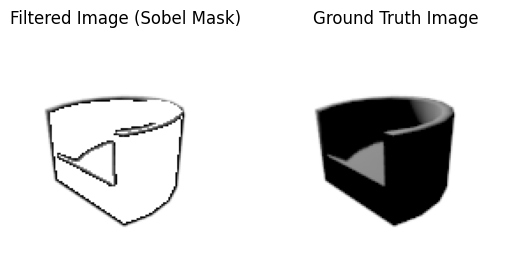

In [ ]:
data = next(iter(vis_dataloader))
r_idx = 0

gt_image = data["gt_images"][0, r_idx].cpu()

sobel_filter = SobelMask(threshold=0.25)
sobel_filter.eval()
gt_image_filtered = sobel_filter.forward(gt_image)

images_side_by_side(gt_image_filtered, gt_image, "Filtered Image (Sobel Mask)")

## Extended Gaussian Predictor

In [ ]:
class GaussianPredictorPool(torch.nn.Module):
    def __init__(self, size, total_dim, state_dict=None):
        super().__init__()
        self.size = size
        self.base_dim = total_dim // self.size
        self.layers = torch.nn.ModuleList([GaussianSplatPredictor(self.base_dim) for _ in range(self.size)])

        if state_dict is not None:
            assert self.base_dim == 128
            for layer in self.layers:
                layer.load_state_dict(state_dict)

In [ ]:
class MultiGaussianSplatPredictor(nn.Module):
    def __init__(self, parallel_models=4, total_dim=128, scaling_factor=4, state_dict=None):
        super(MultiGaussianSplatPredictor, self).__init__()

        self.parallel_models = parallel_models
        self.total_dim = total_dim

        self.sobel_masks = SobelMaskPool(size=self.parallel_models)
        self.gaussian_models = GaussianPredictorPool(size=self.parallel_models, total_dim=self.total_dim, state_dict=state_dict)
        self.scaling_frequencies = [1 / (scaling_factor**i) for i in range(self.parallel_models)]

    def forward(self, x, source_cameras_view_to_world, source_cameras_view_to_world_quat):
        out_dict = {}
        gaussian_splats_list = []

        iter = zip(self.sobel_masks.layers, self.gaussian_models.layers, self.scaling_frequencies)
        for sobel_layer, gaussian_layer, frequency in iter:
            x_filtered = sobel_layer(x)
            gaussian_splats = gaussian_layer(
                x_filtered,
                source_cameras_view_to_world,
                source_cameras_view_to_world_quat,
            )
            gaussian_splats["scaling"] = gaussian_splats["scaling"] * frequency
            gaussian_splats["opacity"] = gaussian_splats["opacity"] * (1 / self.parallel_models)
            gaussian_splats_list.append(gaussian_splats)

        # Transform (P x key x B x N x ...) into (key x B x N*P x ...)
        for k, v in gaussian_splats_list[0].items():
            out_dict[k] = torch.cat([gaussian_splats[k] for gaussian_splats in gaussian_splats_list], dim=1)

        return out_dict

# Training

## Loss functions

In [ ]:
def l1_loss(network_output, gt):
    return torch.abs((network_output - gt)).mean()

def l2_loss(network_output, gt):
    return ((network_output - gt) ** 2).mean()

lpips_net = fabric.to_device(lpips_lib.LPIPS(net="vgg"))

def lpips_loss(network_output, gt):
    return torch.mean(lpips_net(network_output * 2 - 1, gt * 2 - 1))

def psnr(network_output, gt):
    return -10 * torch.log10(torch.mean((network_output - gt) ** 2, dim=[0, 1, 2])).item()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

## Setup

In [ ]:
# Setup Gaussian Predictor (base)
base_gaussian_predictor = GaussianSplatPredictor(128).to(memory_format=torch.channels_last)
base_optimizer = torch.optim.Adam(params=base_gaussian_predictor.parameters(), lr=learning_rate, eps=1e-15, betas=betas)

base_gaussian_predictor, base_optimizer = fabric.setup(base_gaussian_predictor, base_optimizer)

if fabric.is_global_zero:
    ema = EMA(base_gaussian_predictor, beta=0.9999, update_every=10, update_after_step=100)
    ema = fabric.to_device(ema)

In [ ]:
# Setup Gaussian Predictor (paper weights)
paper_gaussian_predictor = GaussianSplatPredictor(128).to(memory_format=torch.channels_last)
fabric.setup(paper_gaussian_predictor)

_FabricModule(
  (_forward_module): GaussianSplatPredictor(
    (network_with_offset): SingleImageSongUNetPredictor(
      (encoder): SongUNet(
        (enc): ModuleDict(
          (128x128_conv): Conv2d()
          (128x128_block0): UNetBlock(
            (norm0): GroupNorm()
            (conv0): Conv2d()
            (norm1): GroupNorm()
            (conv1): Conv2d()
          )
          (128x128_block1): UNetBlock(
            (norm0): GroupNorm()
            (conv0): Conv2d()
            (norm1): GroupNorm()
            (conv1): Conv2d()
          )
          (128x128_block2): UNetBlock(
            (norm0): GroupNorm()
            (conv0): Conv2d()
            (norm1): GroupNorm()
            (conv1): Conv2d()
          )
          (128x128_block3): UNetBlock(
            (norm0): GroupNorm()
            (conv0): Conv2d()
            (norm1): GroupNorm()
            (conv1): Conv2d()
          )
          (64x64_down): UNetBlock(
            (norm0): GroupNorm()
            (conv0

In [ ]:
# Setup Multi Gaussian Predictor (extended)
multi_scale_gaussian_predictor = MultiGaussianSplatPredictor(4, 128).to(memory_format=torch.channels_last)
multi_optimizer = torch.optim.Adam(params=multi_scale_gaussian_predictor.parameters(), lr=learning_rate, eps=1e-15, betas=betas)
multi_scale_gaussian_predictor, multi_optimizer = fabric.setup(multi_scale_gaussian_predictor, multi_optimizer)

if fabric.is_global_zero:
    multi_ema = EMA(multi_scale_gaussian_predictor, beta=0.9999, update_every=10, update_after_step=100)
    multi_ema = fabric.to_device(multi_ema)

In [ ]:
# Setup Multi Gaussian Predictor (extended, pre-trained)
pretrained_file = os.path.join(PRE_TRAINED_ROOT, f"{data_category}.paper.pt")
checkpoint = torch.load(pretrained_file, map_location="cuda")
state_dict = checkpoint["model_state_dict"]

multi_scale_pre_gaussian_predictor = MultiGaussianSplatPredictor(2, 256, scaling_factor=8, state_dict=state_dict).to(memory_format=torch.channels_last)
multi_pre_optimizer = torch.optim.Adam(params=multi_scale_pre_gaussian_predictor.parameters(), lr=learning_rate, eps=1e-15, betas=betas)
multi_scale_pre_gaussian_predictor, multi_pre_optimizer = fabric.setup(multi_scale_pre_gaussian_predictor, multi_pre_optimizer)

if fabric.is_global_zero:
    multi_pre_ema = EMA(multi_scale_pre_gaussian_predictor, beta=0.9999, update_every=10, update_after_step=100)
    multi_pre_ema = fabric.to_device(multi_pre_ema)

<ipython-input-24-8c53b7c042a5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_file, map_location="cuda")


In [ ]:
lambda_lpips = 0
lambda_l12 = 1 - lambda_lpips

lpips_fn = lpips_loss
loss_fn = l2_loss

## Restore State / Train (Base Model)

In [ ]:
# Restore state
%%capture
pretrained_file = os.path.join(PRE_TRAINED_ROOT, f"{data_category}.base.pt")
if os.path.exists(pretrained_file):
    fabric.load_raw(pretrained_file, base_gaussian_predictor)
    base_gaussian_predictor.eval()
else:
    raise Exception(f"Pre-trained file does not exist: {pretrained_file}")

In [ ]:
# distribute model and training dataset
base_gaussian_predictor.train()
print("Beginning training")

# load pre-existing epoch psnrs so we can append to them
try:
    epoch_psnrs = list(np.loadtxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.base.psnrs.csv"), delimiter=","))
except FileNotFoundError:
    epoch_psnrs = []

for num_epoch in range(iterations//len(dataloader) + 1):
    print(f"starting epoch {num_epoch}")
    for data in tqdm(dataloader, desc="batch", total=len(dataloader)):
        # =============== Prepare input ================
        input_images = data["gt_images"][:, 0]
        view_to_world_transforms = data["view_to_world_transforms"][:, 0]
        view_to_world_transform_quats = data["source_cv2wT_quat"][:, 0]
        gaussian_splats = base_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

        # =============== Render ================
        rendered_images = []
        gt_images = []
        render_psnrs = []

        for b_idx in range(data["gt_images"].shape[0]):
            gaussian_splat = {k: v[b_idx].contiguous() for k, v in gaussian_splats.items()}
            for r_idx in range(1, data["gt_images"].shape[1]):
                image = render_predicted(
                    gaussian_splat,
                    data["world_view_transforms"][b_idx, r_idx],
                    data["full_proj_transforms"][b_idx, r_idx],
                    data["camera_centers"][b_idx, r_idx],
                    background,
                )["render"]
                gt_image = data["gt_images"][b_idx, r_idx]

                rendered_images.append(image)
                gt_images.append(gt_image)
                render_psnrs.append(psnr(image, gt_image))

        rendered_images = torch.stack(rendered_images, dim=0)
        gt_images = torch.stack(gt_images, dim=0)
        epoch_psnrs.append(np.mean(render_psnrs))

        # ============ Loss Computation ===============
        total_loss = loss_fn(rendered_images, gt_images) * lambda_l12 + lpips_fn(rendered_images, gt_images) * lambda_lpips
        fabric.backward(total_loss)

        # ============ Optimization ===============
        base_optimizer.step()
        base_optimizer.zero_grad()

        if fabric.is_global_zero:
            ema.update()

base_gaussian_predictor.eval()
np.savetxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.base.psnrs.csv"), np.array(epoch_psnrs), delimiter=",")
torch.save(base_gaussian_predictor.state_dict(), os.path.join(PRE_TRAINED_ROOT, f"{data_category}.base.pt"))

## Restore State (Pre-trained model from original paper)

In [ ]:
%%capture
pretrained_file = os.path.join(PRE_TRAINED_ROOT, f"{data_category}.paper.pt")
if os.path.exists(pretrained_file):
    checkpoint = torch.load(pretrained_file, map_location="cuda")
    paper_gaussian_predictor.load_state_dict(checkpoint["model_state_dict"])
    paper_gaussian_predictor.eval()
else:
    raise Exception(f"Pre-trained file does not exist: {pretrained_file}")

## Restore State / Train (Extended Model)

In [ ]:
# Restore state
%%capture
pretrained_file = os.path.join(PRE_TRAINED_ROOT, f"{data_category}.multi_scale.pt")
if os.path.exists(pretrained_file):
    fabric.load_raw(pretrained_file, multi_scale_gaussian_predictor)
    multi_scale_gaussian_predictor.eval()
else:
    raise Exception(f"Pre-trained file does not exist: {pretrained_file}")

In [ ]:
# distribute model and training dataset
multi_scale_gaussian_predictor.train()
print("Beginning training")

# load pre-existing epoch psnrs so we can append to them
try:
    epoch_psnrs = list(np.loadtxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.multi_scale.psnrs.csv"), delimiter=","))
except FileNotFoundError:
    epoch_psnrs = []

for num_epoch in range(iterations//len(dataloader) + 1):
    print(f"starting epoch {num_epoch}")
    for data in tqdm(dataloader, desc="batch", total=len(dataloader)):
        # =============== Prepare input ================
        input_images = data["gt_images"][:, 0]
        view_to_world_transforms = data["view_to_world_transforms"][:, 0]
        view_to_world_transform_quats = data["source_cv2wT_quat"][:, 0]
        gaussian_splats = multi_scale_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

        # =============== Render ================
        rendered_images = []
        gt_images = []
        render_psnrs = []

        for b_idx in range(data["gt_images"].shape[0]):
            gaussian_splat = {k: v[b_idx].contiguous() for k, v in gaussian_splats.items()}
            for r_idx in range(1, data["gt_images"].shape[1]):
                image = render_predicted(
                    gaussian_splat,
                    data["world_view_transforms"][b_idx, r_idx],
                    data["full_proj_transforms"][b_idx, r_idx],
                    data["camera_centers"][b_idx, r_idx],
                    background,
                )["render"]
                gt_image = data["gt_images"][b_idx, r_idx]

                rendered_images.append(image)
                gt_images.append(gt_image)
                render_psnrs.append(psnr(image, gt_image))

        rendered_images = torch.stack(rendered_images, dim=0)
        gt_images = torch.stack(gt_images, dim=0)
        epoch_psnrs.append(np.mean(render_psnrs))

        # ============ Loss Computation ===============
        if lambda_lpips != 0:
            total_loss = loss_fn(rendered_images, gt_images) * lambda_l12 + lpips_fn(rendered_images, gt_images) * lambda_lpips
        else:
            total_loss = loss_fn(rendered_images, gt_images)
        fabric.backward(total_loss)

        # ============ Optimization ===============
        multi_optimizer.step()
        multi_optimizer.zero_grad()

        if fabric.is_global_zero:
            multi_ema.update()

multi_scale_gaussian_predictor.eval()
np.savetxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.multi_scale.psnrs.csv"), np.array(epoch_psnrs), delimiter=",")
torch.save(multi_scale_gaussian_predictor.state_dict(), os.path.join(PRE_TRAINED_ROOT, f"{data_category}.multi_scale.pt"))

Beginning training
starting epoch 0


batch: 100%|██████████| 1153/1153 [14:59<00:00,  1.28it/s]


starting epoch 1


batch: 100%|██████████| 1153/1153 [08:31<00:00,  2.26it/s]


starting epoch 2


batch: 100%|██████████| 1153/1153 [08:24<00:00,  2.28it/s]


starting epoch 3


batch: 100%|██████████| 1153/1153 [08:22<00:00,  2.30it/s]


starting epoch 4


batch: 100%|██████████| 1153/1153 [08:22<00:00,  2.29it/s]


starting epoch 5


batch: 100%|██████████| 1153/1153 [08:22<00:00,  2.30it/s]


starting epoch 6


batch: 100%|██████████| 1153/1153 [08:22<00:00,  2.30it/s]


starting epoch 7


batch: 100%|██████████| 1153/1153 [08:23<00:00,  2.29it/s]


starting epoch 8


batch: 100%|██████████| 1153/1153 [08:23<00:00,  2.29it/s]


## Restore State / Train (Extended Pre-trained Model)

In [ ]:
# Restore state
%%capture
pretrained_file = os.path.join(PRE_TRAINED_ROOT, f"{data_category}.multi_scale_pre.pt")
if os.path.exists(pretrained_file):
    fabric.load_raw(pretrained_file, multi_scale_pre_gaussian_predictor)
    multi_scale_pre_gaussian_predictor.eval()
else:
    raise Exception(f"Pre-trained file does not exist: {pretrained_file}")

In [ ]:
# distribute model and training dataset
multi_scale_pre_gaussian_predictor.train()
print("Beginning training")

# load pre-existing epoch psnrs so we can append to them
try:
    epoch_psnrs = list(np.loadtxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.multi_scale_pre.psnrs.csv"), delimiter=","))
except FileNotFoundError:
    epoch_psnrs = []

for num_epoch in range(1000//len(dataloader) + 1):
    print(f"starting epoch {num_epoch}")
    for data in tqdm(dataloader, desc="batch", total=len(dataloader)):
        # =============== Prepare input ================
        input_images = data["gt_images"][:, 0]
        view_to_world_transforms = data["view_to_world_transforms"][:, 0]
        view_to_world_transform_quats = data["source_cv2wT_quat"][:, 0]
        gaussian_splats = multi_scale_pre_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

        # =============== Render ================
        rendered_images = []
        gt_images = []
        render_psnrs = []

        for b_idx in range(data["gt_images"].shape[0]):
            gaussian_splat = {k: v[b_idx].contiguous() for k, v in gaussian_splats.items()}
            for r_idx in range(1, data["gt_images"].shape[1]):
                image = render_predicted(
                    gaussian_splat,
                    data["world_view_transforms"][b_idx, r_idx],
                    data["full_proj_transforms"][b_idx, r_idx],
                    data["camera_centers"][b_idx, r_idx],
                    background,
                )["render"]
                gt_image = data["gt_images"][b_idx, r_idx]

                rendered_images.append(image)
                gt_images.append(gt_image)
                render_psnrs.append(psnr(image, gt_image))

        rendered_images = torch.stack(rendered_images, dim=0)
        gt_images = torch.stack(gt_images, dim=0)
        epoch_psnrs.append(np.mean(render_psnrs))

        # ============ Loss Computation ===============
        if lambda_lpips != 0:
            total_loss = loss_fn(rendered_images, gt_images) * lambda_l12 + lpips_fn(rendered_images, gt_images) * lambda_lpips
        else:
            total_loss = loss_fn(rendered_images, gt_images)
        fabric.backward(total_loss)

        # ============ Optimization ===============
        multi_pre_optimizer.step()
        multi_pre_optimizer.zero_grad()

        if fabric.is_global_zero:
            multi_pre_ema.update()

multi_scale_pre_gaussian_predictor.eval()
np.savetxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.multi_scale_pre.psnrs.csv"), np.array(epoch_psnrs), delimiter=",")
torch.save(multi_scale_pre_gaussian_predictor.state_dict(), os.path.join(PRE_TRAINED_ROOT, f"{data_category}.multi_scale_pre.pt"))

Beginning training
starting epoch 0


batch: 100%|██████████| 615/615 [11:12<00:00,  1.09s/it]


starting epoch 1


batch: 100%|██████████| 615/615 [08:13<00:00,  1.25it/s]


# Evaluation

In [ ]:
data = next(iter(vis_dataloader))
r_idx = 1

input_images = data["gt_images"][:, 0]
view_to_world_transforms = data["view_to_world_transforms"][:, 0]
view_to_world_transform_quats = data["source_cv2wT_quat"][:, 0]

In [ ]:
def compute_mean_psnrs(gaussian_predictor, model_name):
    mean_psnrs = []

    for d_idx, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        example_id = val_dataloader.dataset.get_example_id(d_idx)

        render_psnrs = []
        input_images = data["gt_images"][:, 0]
        view_to_world_transforms = data["view_to_world_transforms"][:, 0]
        view_to_world_transform_quats = data["source_cv2wT_quat"][:, 0]
        gaussian_splats = gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

        with torch.no_grad():
            # render image from all available views
            for r_idx in range(1, data["gt_images"].shape[1]):
                rendered_image = render_predicted(
                    {k: v[0].contiguous() for k, v in gaussian_splats.items()},
                    data["world_view_transforms"][0, r_idx],
                    data["full_proj_transforms"][0, r_idx],
                    data["camera_centers"][0, r_idx],
                    background,
                )["render"]
                gt_image = data["gt_images"][0, r_idx]
                render_psnrs.append(psnr(rendered_image, gt_image))

            mean_psnrs.append(np.mean(render_psnrs))

            # cache to file
            with open(os.path.join(OUTPUTS_ROOT, f"{data_category}.{model_name.lower()}.mean_psnrs.csv"), "a+") as f:
                f.write(f"{d_idx},{example_id},{str(mean_psnrs[-1])}\n")
    print(f"mean of means: {np.mean(mean_psnrs)}")
    return mean_psnrs

In [ ]:
def compare_significance_mean_psnrs(model_name, base_model_name, decimal_places=1):
    # Significance Testing on two lists of PSNRS
    # probability: probability of the null hypothesis
    # success: true if model better than base_model

    model_psnrs_dict = {}
    base_model_psnrs_dict = {}

    with open(os.path.join(OUTPUTS_ROOT, f"{data_category}.{model_name.lower()}.mean_psnrs.csv")) as f:
        for line in f:
            i, idx, psnr = line.split(",")
            model_psnrs_dict[idx] = round(float(psnr), decimal_places)

    with open(os.path.join(OUTPUTS_ROOT, f"{data_category}.{base_model_name.lower()}.mean_psnrs.csv")) as f:
        for line in f:
            i, idx, psnr = line.split(",")
            base_model_psnrs_dict[idx] = round(float(psnr), decimal_places)

    minus = 0
    null = 0
    plus = 0

    for k in model_psnrs_dict.keys():
        if model_psnrs_dict[k] < base_model_psnrs_dict[k]:
            minus += 1
        elif model_psnrs_dict[k] == base_model_psnrs_dict[k]:
            null += 1
        else:
            plus += 1

    n = 2 * (null // 2) + plus + minus
    k = (null // 2) + min(plus, minus)
    success = plus >= minus
    probability = 0
    for i in range(k+1):
        probability += math.comb(n, i) * pow(0.5, n)
    return 2 * probability, success

## Base Model

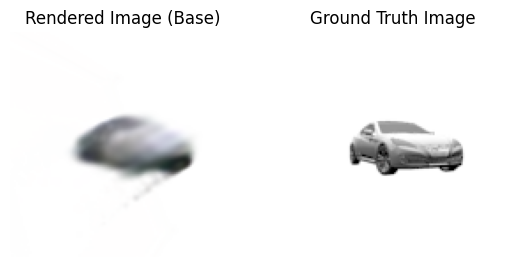

In [ ]:
base_gaussian_splats = base_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

# Render the chosen sample with base model
with torch.no_grad():
    rendered_image = render_predicted(
        {k: v[0].contiguous() for k, v in base_gaussian_splats.items()},
        data["world_view_transforms"][0, r_idx],
        data["full_proj_transforms"][0, r_idx],
        data["camera_centers"][0, r_idx],
        background,
    )["render"]

images_side_by_side(rendered_image, data["gt_images"][0, r_idx], "Rendered Image (Base)")

## Pre-trained model from original paper

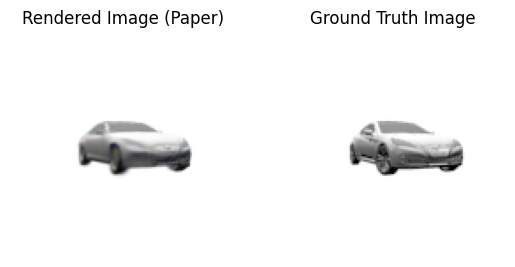

In [ ]:
paper_gaussian_splats = paper_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

# Render the chosen sample with base model
with torch.no_grad():
    rendered_image = render_predicted(
        {k: v[0].contiguous() for k, v in paper_gaussian_splats.items()},
        data["world_view_transforms"][0, r_idx],
        data["full_proj_transforms"][0, r_idx],
        data["camera_centers"][0, r_idx],
        background,
    )["render"]

images_side_by_side(rendered_image, data["gt_images"][0, r_idx], "Rendered Image (Paper)")

## Extended Model

Threshold=0.00, mean scale: 0.009824049659073353

Threshold=0.08, mean scale: 0.0049174027517437935

Threshold=0.17, mean scale: 0.0009516584104858339

Threshold=0.25, mean scale: 0.0001259909913642332



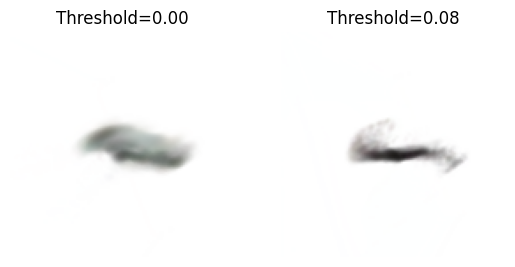

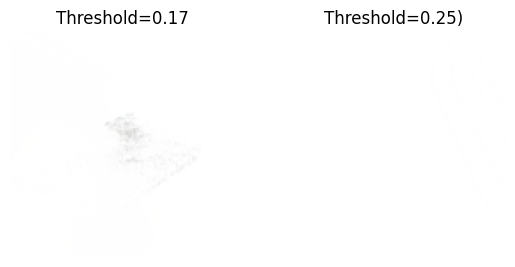

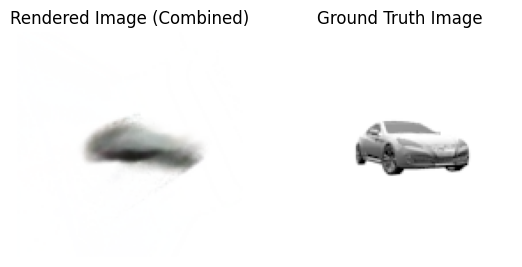

In [ ]:
multi_scale_gaussian_splats = multi_scale_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

full_splat = {k: v[0].contiguous() for k, v in multi_scale_gaussian_splats.items()}
thresholds = torch.round(torch.linspace(0.0, 0.25, 4), decimals=2)
layered_splat = [{}, {}, {}, {}]
layered_image = []

for k, v in full_splat.items():
    layered_splat[0][k], layered_splat[1][k], layered_splat[2][k], layered_splat[3][k] = torch.chunk(v, 4)

# Render the chosen sample with extended model
with torch.no_grad():
    rendered_image = render_predicted(
        full_splat,
        data["world_view_transforms"][0, r_idx],
        data["full_proj_transforms"][0, r_idx],
        data["camera_centers"][0, r_idx],
        background,
    )["render"]
    for splat, threshold in zip(layered_splat, thresholds):
        layered_image.append(render_predicted(
            splat,
            data["world_view_transforms"][0, r_idx],
            data["full_proj_transforms"][0, r_idx],
            data["camera_centers"][0, r_idx],
            background,
        )["render"])
        print(f"Threshold={threshold:.2f}, mean scale: {torch.mean(splat['scaling'])}\n")

images_side_by_side(layered_image[0], layered_image[1], f"Threshold={thresholds[0]:.2f}", f"Threshold={thresholds[1]:.2f}")
images_side_by_side(layered_image[2], layered_image[3], f"Threshold={thresholds[2]:.2f}", f"Threshold={thresholds[3]:.2f})")
images_side_by_side(rendered_image, data["gt_images"][0, r_idx], "Rendered Image (Combined)")

##Extended Pre-trained Model

Threshold=0.0, mean scale: 0.011852162890136242

Threshold=0.25, mean scale: 0.0018428654875606298



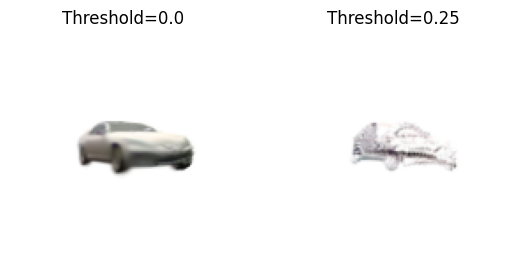

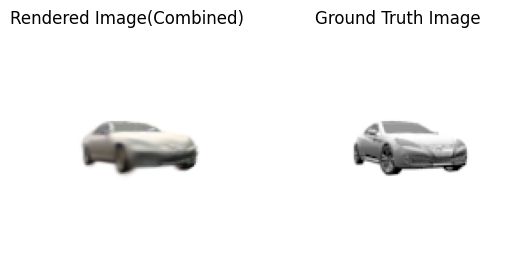

In [ ]:
multi_scale_pre_gaussian_splats = multi_scale_pre_gaussian_predictor(input_images, view_to_world_transforms, view_to_world_transform_quats)

full_splat = {k: v[0].contiguous() for k, v in multi_scale_pre_gaussian_splats.items()}
thresholds = torch.round(torch.linspace(0.0, 0.25, 2), decimals=2)
layered_splat = [{}, {}]
layered_image = []

for k, v in full_splat.items():
    layered_splat[0][k], layered_splat[1][k], = torch.chunk(v, 2)

# Render the chosen sample with extended model
with torch.no_grad():
    rendered_image = render_predicted(
        full_splat,
        data["world_view_transforms"][0, r_idx],
        data["full_proj_transforms"][0, r_idx],
        data["camera_centers"][0, r_idx],
        background,
    )["render"]
    for splat, threshold in zip(layered_splat, thresholds):
        layered_image.append(render_predicted(
            splat,
            data["world_view_transforms"][0, r_idx],
            data["full_proj_transforms"][0, r_idx],
            data["camera_centers"][0, r_idx],
            background,
        )["render"])
        print(f"Threshold={threshold}, mean scale: {torch.mean(splat['scaling'])}\n")

images_side_by_side(layered_image[0], layered_image[1], f"Threshold={thresholds[0]}", f"Threshold={thresholds[1]}")
images_side_by_side(rendered_image, data["gt_images"][0, r_idx], "Rendered Image(Combined)")

## Quantitative Analysis

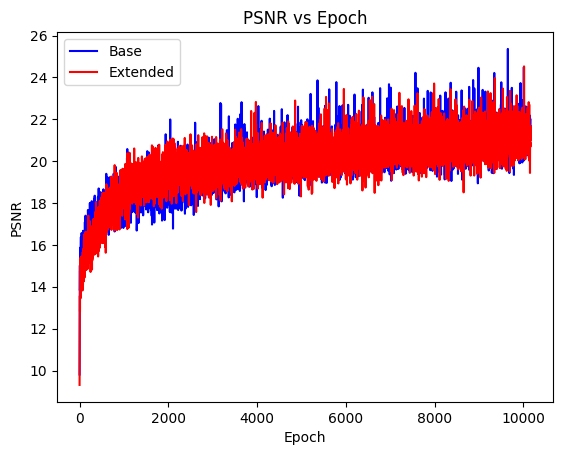

In [ ]:
epoch_psnrs_base = np.loadtxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.base.psnrs.csv"), delimiter=",")
epoch_psnrs_multi_scale = np.loadtxt(os.path.join(OUTPUTS_ROOT, f"{data_category}.multi_scale.psnrs.csv"), delimiter=",")

plt.plot(range(len(epoch_psnrs_base)), epoch_psnrs_base, "b", label="Base")
plt.plot(range(len(epoch_psnrs_multi_scale)), epoch_psnrs_multi_scale, "r", label="Extended")

plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("PSNR vs Epoch")
plt.legend()

plt.show()

In [ ]:
# Generate mean PSNRs
compute_mean_psnrs(base_gaussian_predictor, "base")
compute_mean_psnrs(paper_gaussian_predictor, "paper")
compute_mean_psnrs(multi_scale_gaussian_predictor, "multi_scale")
compute_mean_psnrs(multi_scale_pre_gaussian_predictor, "multi_scale_pre")

100%|██████████| 662/662 [06:20<00:00,  1.74it/s]


mean of means: 18.61094530331044


100%|██████████| 662/662 [02:50<00:00,  3.89it/s]


mean of means: 24.659329442606953


100%|██████████| 662/662 [05:12<00:00,  2.12it/s]


mean of means: 17.303151066112374


100%|██████████| 662/662 [03:52<00:00,  2.84it/s]

mean of means: 23.347377657857905
chairs multi-scale: success=False, p-value=7.647234193620136e-105
chairs multi-scale pre-trained: success=False, p-value=1.1340927478574628e-107


In [ ]:
probability_1, success_1 = compare_significance_mean_psnrs("multi_scale", "base", 0)
print(f"{data_category} multi-scale: success={success_1}, p-value={probability_1}")

probability_2, success_2 = compare_significance_mean_psnrs("multi_scale_pre", "paper")
print(f"{data_category} multi-scale pre-trained: success={success_2}, p-value={probability_2}", 0)

chairs multi-scale: success=False, p-value=9.567911583201095e-95
chairs multi-scale pre-trained: success=False, p-value=1.1340927478574628e-107 0


In [ ]:
drive.flush_and_unmount()